### Exploratory Analysis of a Clinical trial on Anti-TNF Agents in Rheumatoid Arthritis Patients 
In this tutorial, we will use python and jupyter notebook to analyze study [SDY824](https://www.immport.org/shared/study/SDY824), a clinical trial that compared two anti-TNF drugs, Etanercept and Adalimumab, in Rheumatoid Arthritis Patients. 

We will learn the following skills in the tutorial:
* Use python and the popular library Pandas to manipulate data.
* Navigate through the ImmPort database.
* Data visualization using the seaborn library.
* Perform statistical test using mixed effect models.

Using these skills, we will achieve the following scientific goals:
* Compare the demographics between the two treatment arms. 
* Visualize the data from different lab tests.
* Identify measurements that are significantly different between the two treatment arms. 

In [1]:
##### import libraries #####
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
##### view the design of the study #####
arms = pd.read_csv("SDY824-DR36_Tab/Tab/arm_or_cohort.txt",sep='\t')
arms = arms.query('STUDY_ACCESSION == "SDY824"')
display(arms.head())
print(arms.DESCRIPTION.values)

,ARM_ACCESSION,DESCRIPTION,NAME,STUDY_ACCESSION,TYPE,WORKSPACE_ID
0,ARM3215,Participants receive a subcutaneous injection ...,Etanercept Experimental,SDY824,Experimental,5300
1,ARM3216,Participants receive a subcutaneous injection ...,Adalimumab Experimental,SDY824,Experimental,5300


['Participants receive a subcutaneous injection of etanercept once every week for 24 weeks'
 'Participants receive a subcutaneous injection of adalimumab once every 2 weeks for 24 weeks']


------
### Navigate the ImmPort data model
In the next few code blocks, we will navigate throught the ImmPort data model to gather subject information and lab tests measurement. 

<img src="ImmPort_data_structure.png" alt="ImmPort Data Model" width="800"/>

In [3]:
##### assign subject to the arms #####
arm2subj = pd.read_csv("SDY824-DR36_Tab/Tab/arm_2_subject.txt",sep='\t')
subj = arm2subj.merge(arms, how='inner', on="ARM_ACCESSION")
subj = subj[["ARM_ACCESSION","SUBJECT_ACCESSION","MIN_SUBJECT_AGE","NAME","STUDY_ACCESSION"]]
display(subj.head())

,ARM_ACCESSION,SUBJECT_ACCESSION,MIN_SUBJECT_AGE,NAME,STUDY_ACCESSION
0,ARM3215,SUB169152,52,Etanercept Experimental,SDY824
1,ARM3215,SUB169153,43,Etanercept Experimental,SDY824
2,ARM3215,SUB169154,41,Etanercept Experimental,SDY824
3,ARM3215,SUB169156,32,Etanercept Experimental,SDY824
4,ARM3215,SUB169157,45,Etanercept Experimental,SDY824


In [4]:
#### join with subject information #####
subj_info = pd.read_csv("SDY824-DR36_Tab/Tab/subject.txt",sep='\t')
subj_info = subj_info[["SUBJECT_ACCESSION","GENDER", "RACE"]]
subj_info = subj_info.merge(subj, how='inner', on=["SUBJECT_ACCESSION"])
display(subj_info.head())

,SUBJECT_ACCESSION,GENDER,RACE,ARM_ACCESSION,MIN_SUBJECT_AGE,NAME,STUDY_ACCESSION
0,SUB169152,Female,White,ARM3215,52,Etanercept Experimental,SDY824
1,SUB169153,Female,White,ARM3215,43,Etanercept Experimental,SDY824
2,SUB169154,Female,White,ARM3215,41,Etanercept Experimental,SDY824
3,SUB169155,Female,White,ARM3216,64,Adalimumab Experimental,SDY824
4,SUB169156,Male,Black or African American,ARM3215,32,Etanercept Experimental,SDY824


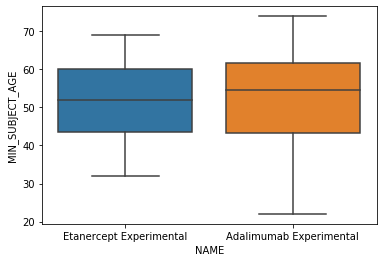

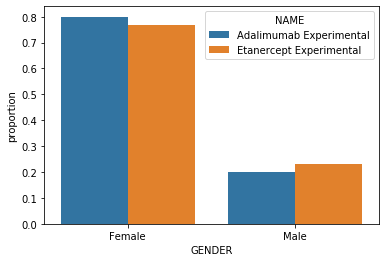

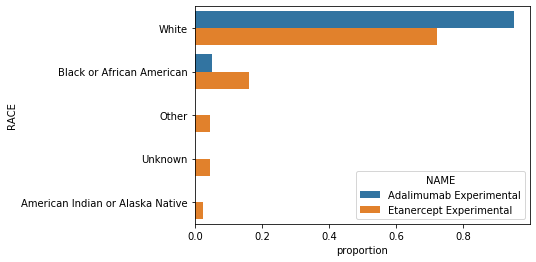

In [5]:
#### plot demographics #####
sns.boxplot(x="NAME", y="MIN_SUBJECT_AGE", data=subj_info)
plt.show()

gender_plot = subj_info.groupby(['NAME'])['GENDER'].value_counts(normalize=True)
gender_plot = gender_plot.rename('proportion').reset_index()
sns.barplot(x="GENDER", y="proportion",hue='NAME', data=gender_plot)
plt.show()

race_plot = subj_info.groupby(['NAME'])['RACE'].value_counts(normalize=True)
race_plot = race_plot.rename('proportion').reset_index()
sns.barplot(y="RACE", x="proportion",hue='NAME', data=race_plot)
plt.show()

In [6]:
##### assign biosample to the subjects #####
biosample = pd.read_csv("SDY824-DR36_Tab/Tab/biosample.txt",sep='\t')
biosample = biosample[["BIOSAMPLE_ACCESSION","STUDY_TIME_COLLECTED", "SUBJECT_ACCESSION","STUDY_ACCESSION"]]
biosample = biosample.merge(subj_info, how='inner', on=["SUBJECT_ACCESSION","STUDY_ACCESSION"])
display(biosample.head())

,BIOSAMPLE_ACCESSION,STUDY_TIME_COLLECTED,SUBJECT_ACCESSION,STUDY_ACCESSION,GENDER,RACE,ARM_ACCESSION,MIN_SUBJECT_AGE,NAME
0,BS913115,66,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental
1,BS913116,122,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental
2,BS913117,182,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental
3,BS913315,-7,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental
4,BS913316,13,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental


In [7]:
#### join with lab test result #####
lab = pd.read_csv("SDY824-DR36_Tab/Tab/lab_test.txt",sep='\t')
lab = lab[["BIOSAMPLE_ACCESSION","NAME_PREFERRED","RESULT_UNIT_REPORTED","RESULT_VALUE_PREFERRED"]]
lab = lab.merge(biosample, how='inner', on=["BIOSAMPLE_ACCESSION"])
lab = lab.dropna()
lab['name_plus_unit'] = lab['NAME_PREFERRED'] + " in " +lab['RESULT_UNIT_REPORTED']
display(lab.head())

,BIOSAMPLE_ACCESSION,NAME_PREFERRED,RESULT_UNIT_REPORTED,RESULT_VALUE_PREFERRED,STUDY_TIME_COLLECTED,SUBJECT_ACCESSION,STUDY_ACCESSION,GENDER,RACE,ARM_ACCESSION,MIN_SUBJECT_AGE,NAME,name_plus_unit
0,BS913115,Albumin,g/dL,4.0,66,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental,Albumin in g/dL
1,BS913115,Alanine Aminotransferase,U/L,13.0,66,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental,Alanine Aminotransferase in U/L
2,BS913115,Aspartate Aminotransferase,U/L,20.0,66,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental,Aspartate Aminotransferase in U/L
3,BS913115,Creatinine,mg/dL,0.8,66,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental,Creatinine in mg/dL
4,BS913115,Hematocrit,%,36.3,66,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental,Hematocrit in %


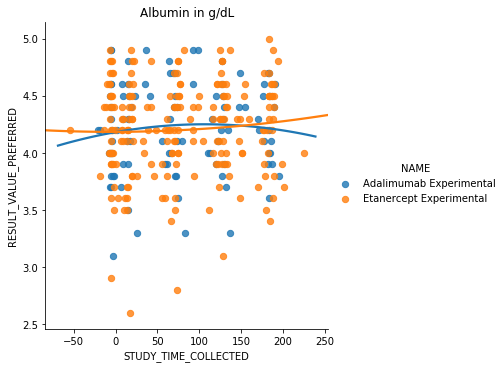

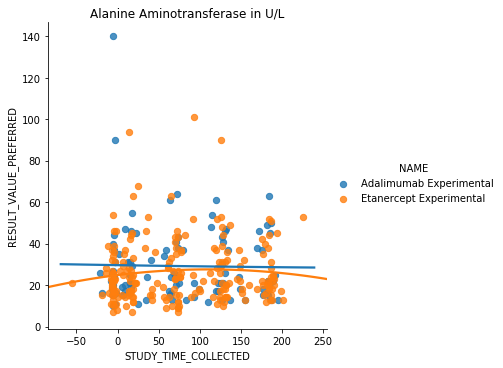

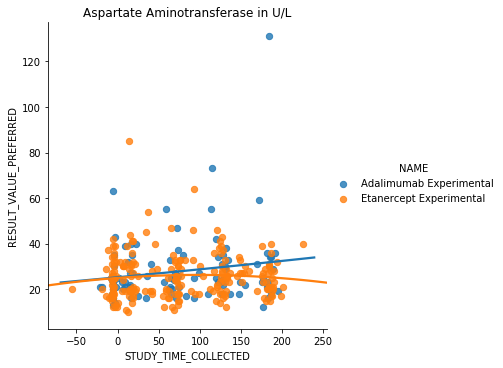

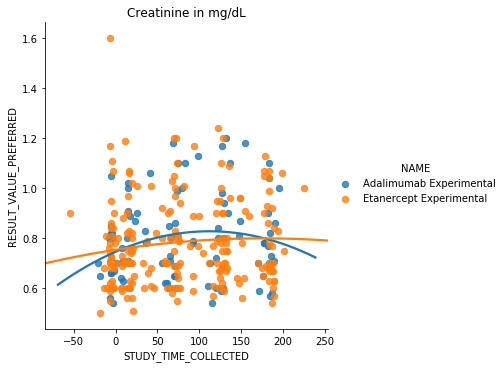

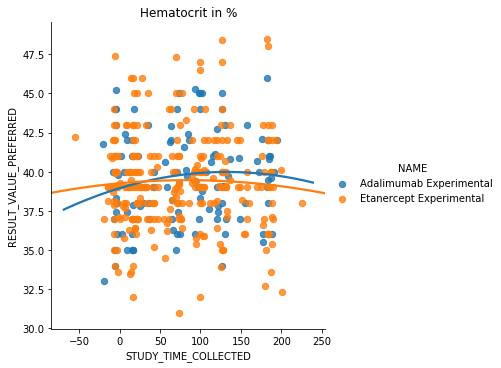

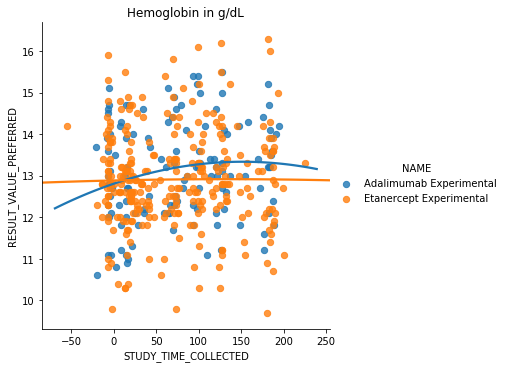

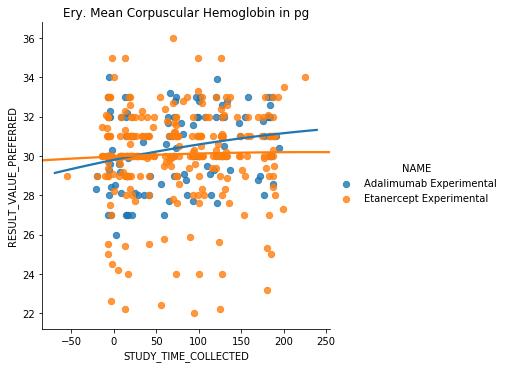

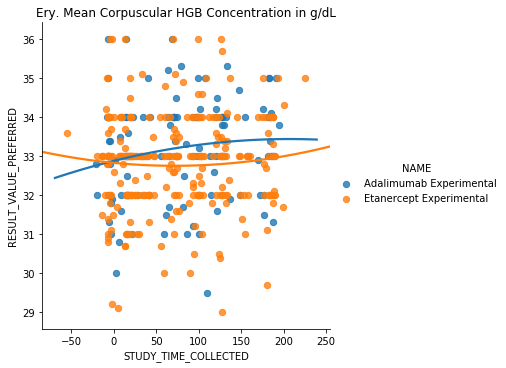

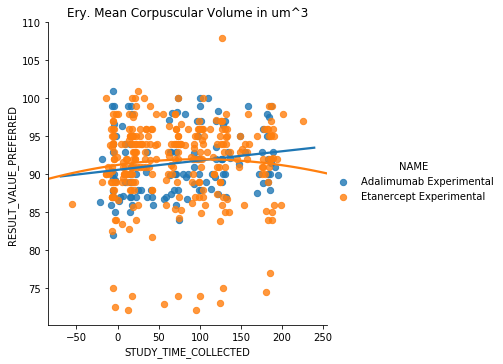

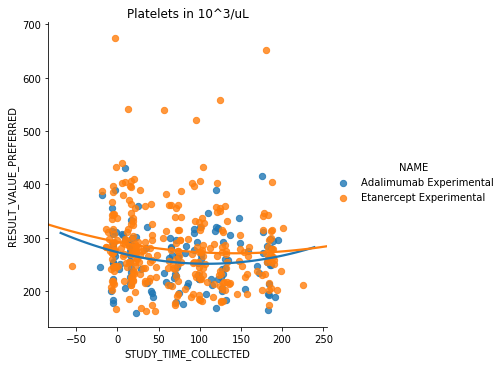

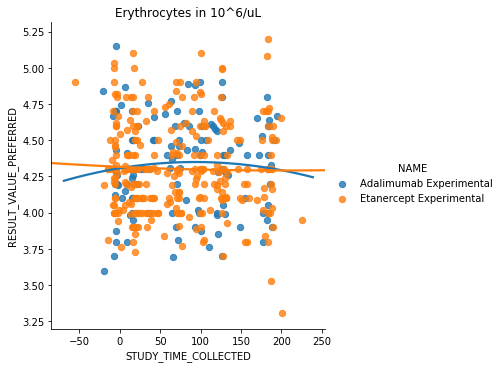

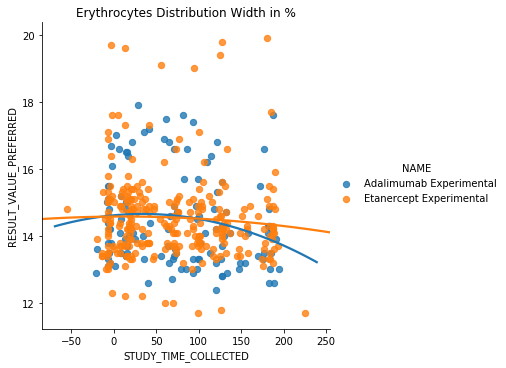

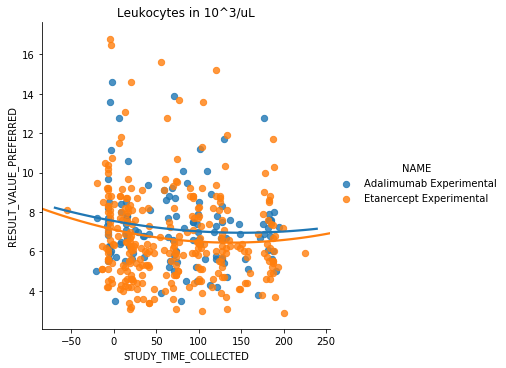

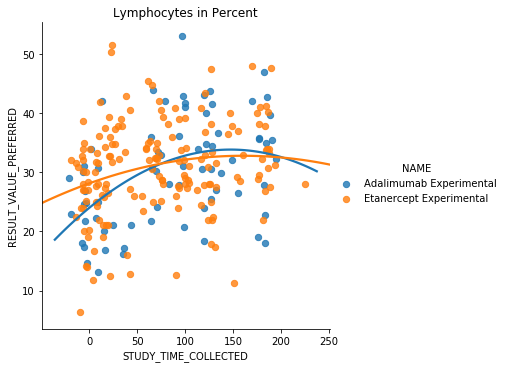

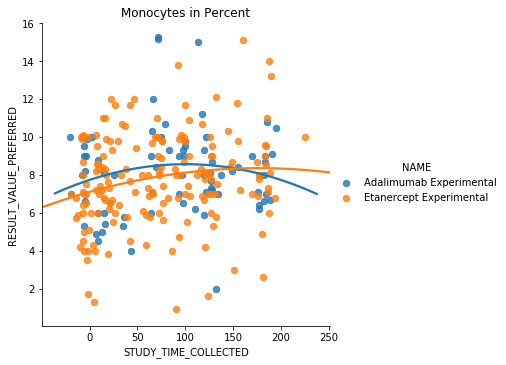

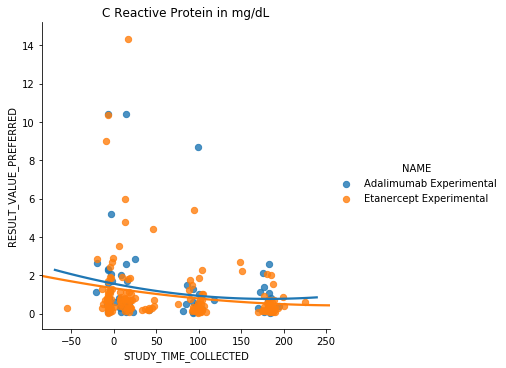

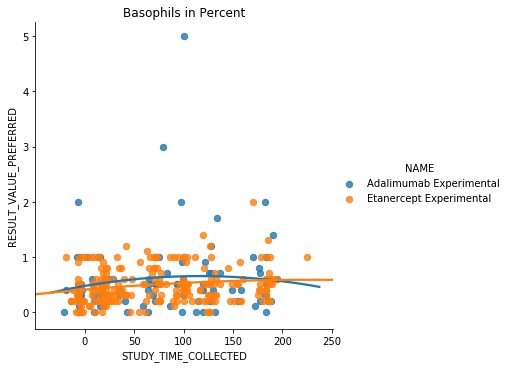

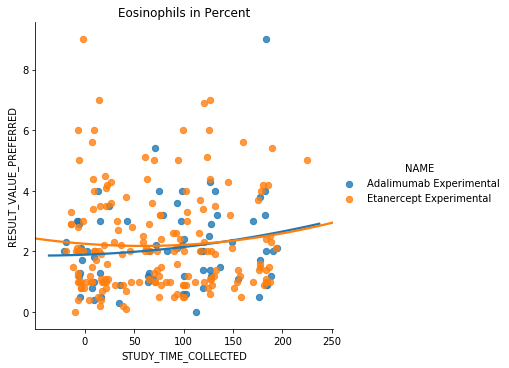

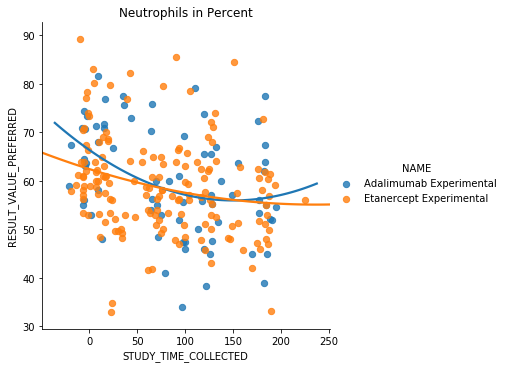

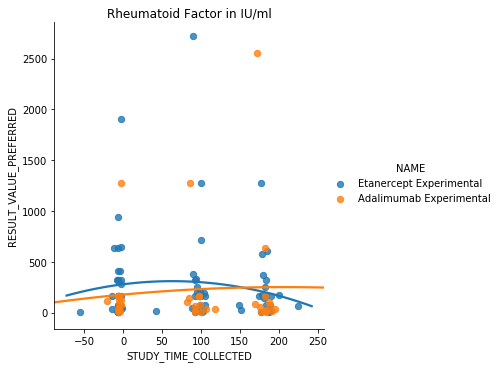

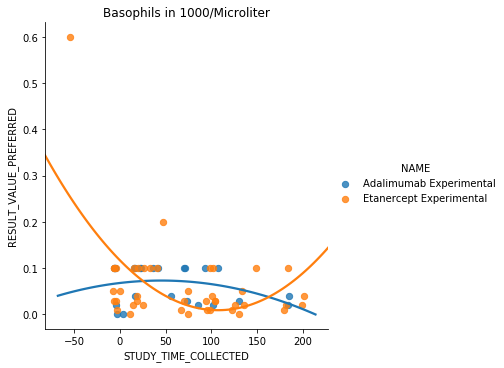

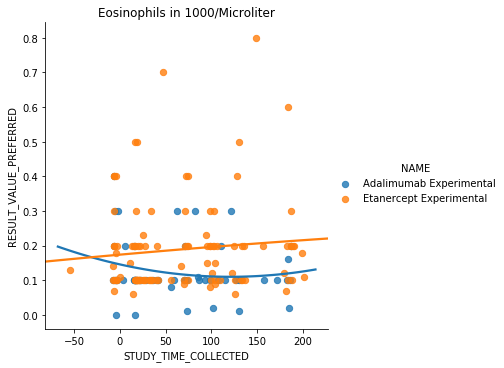

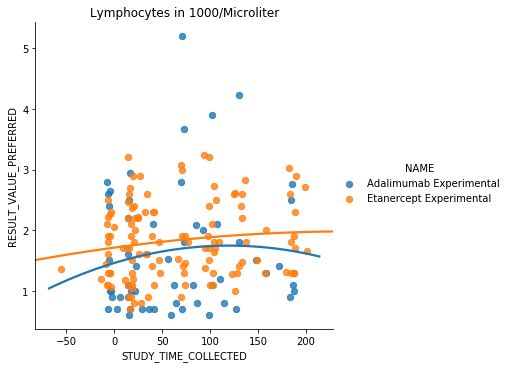

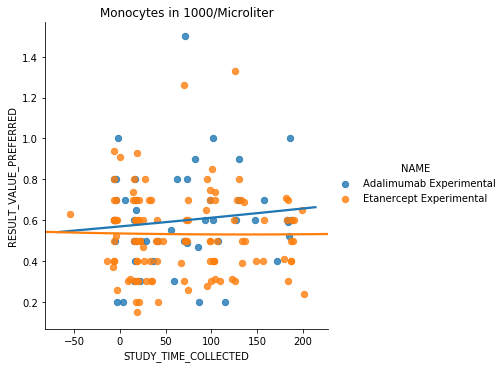

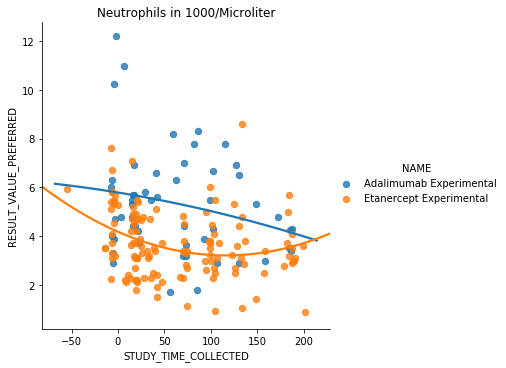

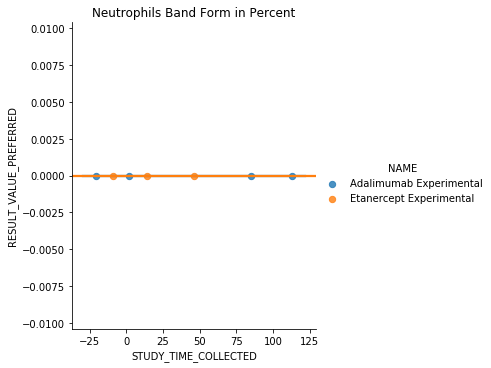

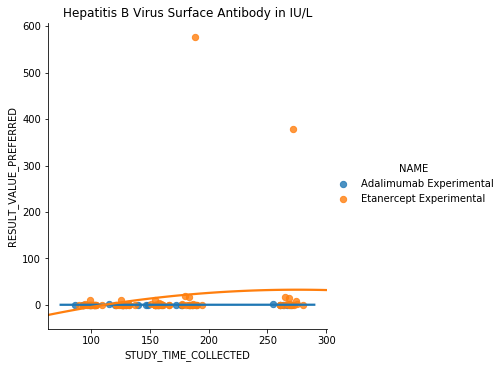

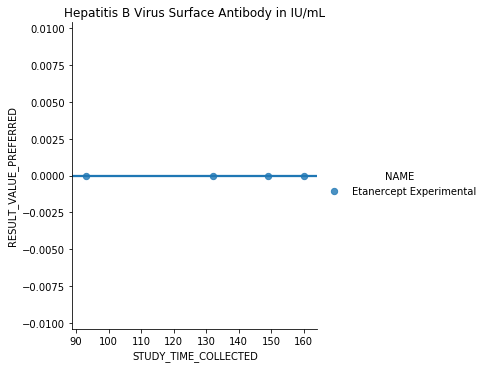

In [8]:
##### visualize the lab test results #####
for name in lab["name_plus_unit"].unique():
    lab_data = lab[lab["name_plus_unit"] == name]
    sns.lmplot(x="STUDY_TIME_COLLECTED", y="RESULT_VALUE_PREFERRED", 
                    order=2, ci=None,scatter_kws={"s": 40},
                    hue="NAME", data=lab_data)
    plt.title(name)
    plt.show()

In [9]:
##### convert time to catogorical variable #####
lab['time'] = ''
lab.loc[lab.STUDY_TIME_COLLECTED<=0,"time"]="T0"
lab.loc[(lab.STUDY_TIME_COLLECTED>0) & (lab.STUDY_TIME_COLLECTED<=50),'time']="T1"
lab.loc[(lab.STUDY_TIME_COLLECTED>50) & (lab.STUDY_TIME_COLLECTED<=100),'time']="T2"
lab.loc[(lab.STUDY_TIME_COLLECTED>100) & (lab.STUDY_TIME_COLLECTED<=150),'time']="T3"
lab.loc[(lab.STUDY_TIME_COLLECTED>150),'time']="T4"
lab.head()

,BIOSAMPLE_ACCESSION,NAME_PREFERRED,RESULT_UNIT_REPORTED,RESULT_VALUE_PREFERRED,STUDY_TIME_COLLECTED,SUBJECT_ACCESSION,STUDY_ACCESSION,GENDER,RACE,ARM_ACCESSION,MIN_SUBJECT_AGE,NAME,name_plus_unit,time
0,BS913115,Albumin,g/dL,4.0,66,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental,Albumin in g/dL,T2
1,BS913115,Alanine Aminotransferase,U/L,13.0,66,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental,Alanine Aminotransferase in U/L,T2
2,BS913115,Aspartate Aminotransferase,U/L,20.0,66,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental,Aspartate Aminotransferase in U/L,T2
3,BS913115,Creatinine,mg/dL,0.8,66,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental,Creatinine in mg/dL,T2
4,BS913115,Hematocrit,%,36.3,66,SUB169158,SDY824,Female,White,ARM3216,61,Adalimumab Experimental,Hematocrit in %,T2


In [10]:
##### analyze lab tests using mixed models #####
test_result = pd.DataFrame({'lab':lab["name_plus_unit"].unique(), 'p':1})
for i in range(test_result.shape[0]):
    lab_data = lab[lab["name_plus_unit"] == test_result.lab[i]]
    if(lab_data.shape[0]<20): continue
    mix_model = smf.mixedlm("RESULT_VALUE_PREFERRED ~ time + NAME", lab_data, groups=lab_data["SUBJECT_ACCESSION"])
    mix_model = mix_model.fit()
    test_result.loc[i,"p"] = mix_model.pvalues["NAME[T.Etanercept Experimental]"]
test_result = test_result.sort_values("p").reset_index(drop = True)
display(test_result)

/Users/zichenghu/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


,lab,p
0,Neutrophils in 1000/Microliter,0.037393
1,Eosinophils in 1000/Microliter,0.068776
2,Aspartate Aminotransferase in U/L,0.172889
3,Platelets in 10^3/uL,0.213686
4,Basophils in Percent,0.216790
5,Monocytes in Percent,0.282496
6,Alanine Aminotransferase in U/L,0.304832
7,Ery. Mean Corpuscular HGB Concentration in g/dL,0.305237
8,Ery. Mean Corpuscular Hemoglobin in pg,0.319757
9,Basophils in 1000/Microliter,0.398617


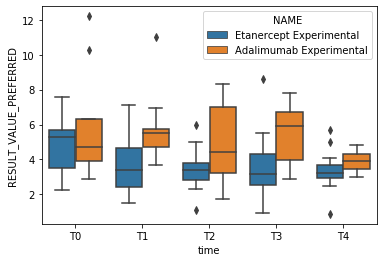

In [11]:
##### look at neutrophil numbers again #####

neutrophil_lab = lab[lab["name_plus_unit"] == "Neutrophils in 1000/Microliter"]
neutrophil_lab = neutrophil_lab.sort_values('time')
sns.boxplot(x="time", y="RESULT_VALUE_PREFERRED", 
                    hue="NAME", data=neutrophil_lab)

### Summary

In this tutorial, we analyzed the data from SDY 824. We successfully navigated through the ImmPort data model and gathered subject-level information and measurements from lab tests. We confirmed that the cohorts in the two arms are comparable. We visualized the lab test data and used mixed linear models to identify differences between the two arms. The result shows that there are a higher number of neutrophils in the Adalimumab arm.